In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
import argparse

from collections import defaultdict, namedtuple

import numpy as np
import cv2
import g2o

from dataset import TUMRGBDDataset
from feature import Params, ImageFeature
from components import Camera, RGBDFrame, depth_to_3d
from viewer import SimpleMapViewer

dataset = TUMRGBDDataset('images/')

height, width = dataset.rgb.shape[:2]
params = Params()
cam = Camera(
    dataset.cam.fx, dataset.cam.fy, dataset.cam.cx, dataset.cam.cy, 
    width, height, dataset.cam.scale, params.depth_near, params.depth_far)

view_point_cloud = params.view_point_cloud

In [4]:
######################### Load Data #########################

kfs = []
last_kf = None

for i in range(len(dataset))[:]:
    feature = ImageFeature(dataset.rgb[i], params)
    depth = dataset.depth[i]
    timestamp = dataset.timestamps[i]
    pose = np.load('images/pose/%.6f.npy' % timestamp)

    feature.extract()
    frame = RGBDFrame(i, g2o.Isometry3d(pose), feature, depth, cam, timestamp=timestamp)
    keyFrame = frame.to_keyframe()

    if view_point_cloud:
        keyFrame.cloudify()

    if last_kf is None:
        kfs.append(keyFrame)
        last_kf = keyFrame
        continue

    keyFrame.update_reference(last_kf)
    kfs.append(keyFrame)
    last_kf = keyFrame

In [5]:
######################### Loop Detection(Required part for student) #########################

class LoopDetection(object):
    def __init__(self, params):
        self.params = params

    def add_keyframe(self, keyframe):
        pass
        # Optional function, add keyframe to the loop closure detector
    
    def detect(self, keyframe):
        # return a condidate keyframe or 'None' if there is no candidate or failed to detect any.
        pass

In [6]:
######################### Loop Closing #########################

def match_and_estimate(query_keyframe, match_keyframe, params):
    query = defaultdict(list)
    for kp, desp in zip(
        query_keyframe.feature.keypoints, query_keyframe.feature.descriptors):
        query['kps'].append(kp)
        query['desps'].append(desp)
        query['px'].append(kp.pt)

    match = defaultdict(list)
    for kp, desp in zip(
        match_keyframe.feature.keypoints, match_keyframe.feature.descriptors):
        match['kps'].append(kp)
        match['desps'].append(desp)
        match['px'].append(kp.pt)

    matches = query_keyframe.feature.direct_match(
        query['desps'], match['desps'],
        params.matching_distance, 
        params.matching_distance_ratio)

    query_pts = depth_to_3d(query_keyframe.depth, query['px'], query_keyframe.cam)
    match_pts = depth_to_3d(match_keyframe.depth, match['px'], match_keyframe.cam)

    if len(matches) < params.lc_inliers_threshold:
        return None

    near = query_keyframe.cam.depth_near
    far = query_keyframe.cam.depth_far
    for (i, j) in matches:
        if (near <= query_pts[i][2] <= far):
            query['pt12'].append(query_pts[i])
            query['px12'].append(query['kps'][i].pt)
            match['px12'].append(match['kps'][j].pt)
        if (near <= match_pts[j][2] <= far):
            query['px21'].append(query['kps'][i].pt)
            match['px21'].append(match['kps'][j].pt)
            match['pt21'].append(match_pts[j])

    if len(query['pt12']) < 6 or len(match['pt21']) < 6:
        return None

    T12, inliers12 = solve_pnp_ransac(
        query['pt12'], match['px12'], match_keyframe.cam.intrinsic)

    T21, inliers21 = solve_pnp_ransac(
        match['pt21'], query['px21'], query_keyframe.cam.intrinsic)

    if T12 is None or T21 is None:
        return None

    delta = T21 * T12

    if (g2o.AngleAxis(delta.rotation()).angle() > 0.06 or
        np.linalg.norm(delta.translation()) > 0.06):          # 3° or 0.06m
        return None
    
    query_pose = g2o.Isometry3d(
        query_keyframe.orientation, query_keyframe.position)
    match_pose = g2o.Isometry3d(
        match_keyframe.orientation, match_keyframe.position)

    if len(inliers12) > len(inliers21):
        constraint = T12
        n_matches = len(query['pt12'])
        n_inliers = len(inliers12)

    else:
        constraint = T21.inverse()
        n_matches = len(match['pt21'])
        n_inliers = len(inliers21)

    estimated_pose = match_pose * constraint
    correction = query_pose.inverse() * estimated_pose    

    return namedtuple('MatchEstimateResult',
        ['estimated_pose', 'constraint', 'correction', 'n_matches', 'n_inliers'])(
        estimated_pose, constraint, correction, n_matches, n_inliers)

def solve_pnp_ransac(pts3d, pts, intrinsic_matrix):

    try:
        val, rvec, tvec, inliers = cv2.solvePnPRansac(
                np.array(pts3d), np.array(pts), 
                intrinsic_matrix, None, None, None, 
                False, 100, 8.0, 0.999, None)
    except:
        return None, None
        
    if inliers is None or len(inliers) < 5:
        return None, None

    T = g2o.Isometry3d(cv2.Rodrigues(rvec)[0], tvec)
    return T, inliers.ravel()
    
class LoopClosing(object):
    def __init__(self, params):
        self.params = params

        self.loop_detector = LoopDetection(params)

        self.loops = []
        self.stopped = False

    def add_keyframe(self, keyframe):

        self.loop_detector.add_keyframe(keyframe)
        candidate = self.loop_detector.detect(keyframe)

        if candidate is None:
            return False

        query_keyframe = keyframe
        match_keyframe = candidate

        result = match_and_estimate(
            query_keyframe, match_keyframe, self.params)

        if result is None:
            return False

        if (result.n_inliers < max(self.params.lc_inliers_threshold, 
            result.n_matches * self.params.lc_inliers_ratio)):
            return False

        self.loops.append(
            (match_keyframe, query_keyframe, result.constraint))
        query_keyframe.set_loop(match_keyframe, result.constraint)

        print("Found an edge from {} to {}".format(query_keyframe.id, match_keyframe.id))
        
        image_pair = cv2.hconcat([query_keyframe.rgb.image, match_keyframe.rgb.image])
        
        plt.title('loop pair')
        plt.imshow(image_pair)
        plt.show()
        
        return True

In [7]:
######################### Pose Graph Optimization #########################

class PoseGraphOptimization(g2o.SparseOptimizer):
    def __init__(self):
        super().__init__()
        solver = g2o.BlockSolverSE3(g2o.LinearSolverCholmodSE3())
        solver = g2o.OptimizationAlgorithmLevenberg(solver)
        super().set_algorithm(solver)

    def optimize(self, max_iterations=20):
        super().initialize_optimization()
        super().optimize(max_iterations)

    def add_vertex(self, id, pose, fixed=False):
        v_se3 = g2o.VertexSE3()
        v_se3.set_id(id)
        v_se3.set_estimate(pose)
        v_se3.set_fixed(fixed)
        super().add_vertex(v_se3)

    def add_edge(self, vertices, 
            measurement=None, 
            information=np.identity(6),
            robust_kernel=None):

        edge = g2o.EdgeSE3()
        for i, v in enumerate(vertices):
            if isinstance(v, int):
                v = self.vertex(v)
            edge.set_vertex(i, v)

        if measurement is None:
            measurement = (
                edge.vertex(0).estimate().inverse() * 
                edge.vertex(1).estimate())
        edge.set_measurement(measurement)
        edge.set_information(information)
        if robust_kernel is not None:
            edge.set_robust_kernel(robust_kernel)
        super().add_edge(edge)

    def set_data(self, keyframes, loops):
        super().clear()
        anchor=None
        for kf, *_ in loops:
            if anchor is None or kf < anchor:
                anchor = kf

        for i, kf in enumerate(keyframes):
            pose = g2o.Isometry3d(
                kf.orientation,
                kf.position)
            
            fixed = i == 0
            if anchor is not None:
                fixed = kf <= anchor
            self.add_vertex(kf.id, pose, fixed=fixed)

            if kf.reference_keyframe is not None:
                self.add_edge(
                    vertices=(kf.reference_keyframe.id, kf.id),
                    measurement=kf.reference_constraint)
        
        for kf, kf2, meas in loops:
            self.add_edge((kf.id, kf2.id), measurement=meas)

    def update_poses(
            self, keyframes, correction=None, exclude=set(), update_points=False):

        for kf in keyframes:
            if len(exclude) > 0 and kf in exclude:
                continue
            uncorrected = g2o.Isometry3d(kf.orientation, kf.position)
            if correction is None:
                vertex = self.vertex(kf.id)
                if vertex.fixed():
                    continue
                corrected = vertex.estimate()
            else:
                corrected = uncorrected * correction

            delta = uncorrected.inverse() * corrected
            if (g2o.AngleAxis(delta.rotation()).angle() < 0.02 and
                np.linalg.norm(delta.translation()) < 0.03):          # 1°, 3cm
                continue
            kf.update_pose(corrected)

            if update_points:
                for m in kf.mappoints:
                    old = m.position
                    new = corrected * (uncorrected.inverse() * old)
                    m.update_position(new)

Found an edge from 10 to 2


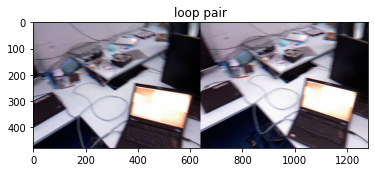

Found an edge from 24 to 22


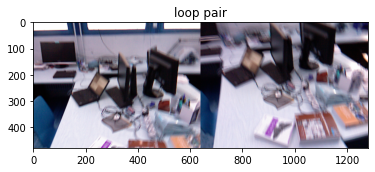

Found an edge from 25 to 23


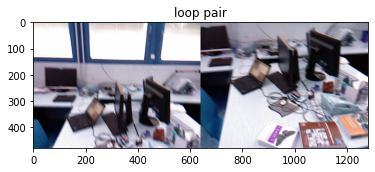

Found an edge from 27 to 25


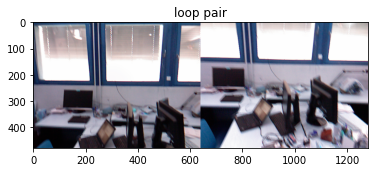

Found an edge from 32 to 30


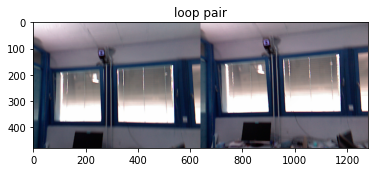

Found an edge from 34 to 32


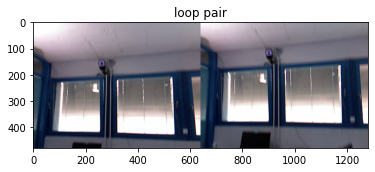

Found an edge from 45 to 43


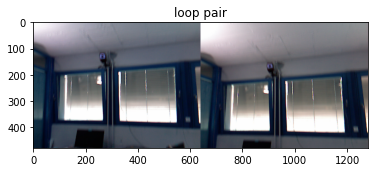

Found an edge from 46 to 43


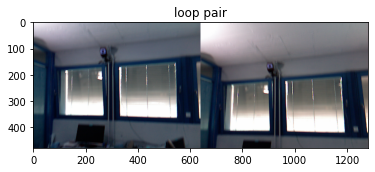

Found an edge from 47 to 43


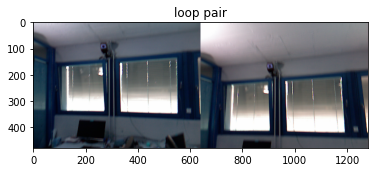

Found an edge from 48 to 46


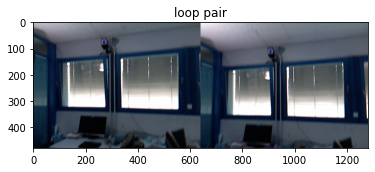

Found an edge from 49 to 47


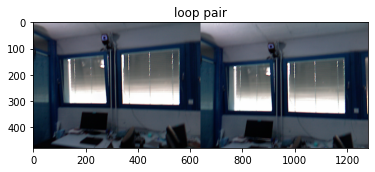

Found an edge from 51 to 49


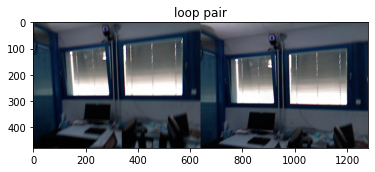

Found an edge from 52 to 49


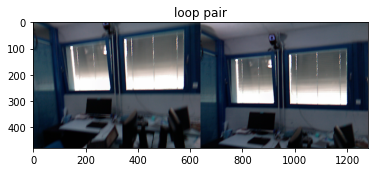

Found an edge from 53 to 51


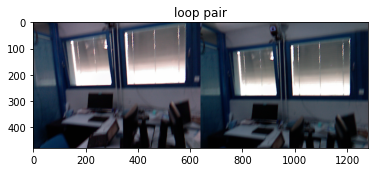

Found an edge from 54 to 52


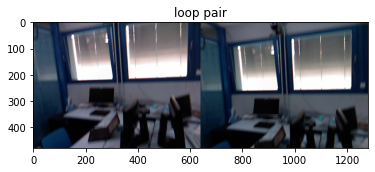

Found an edge from 86 to 84


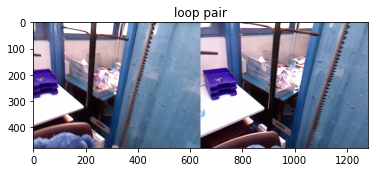

Found an edge from 87 to 85


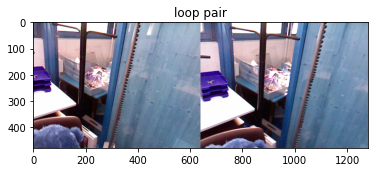

Found an edge from 106 to 104


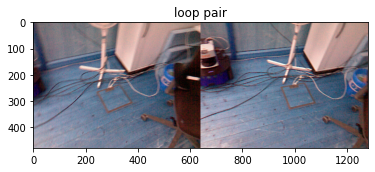

Found an edge from 107 to 105


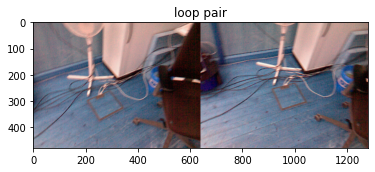

Found an edge from 128 to 125


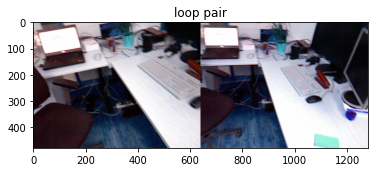

Found an edge from 132 to 128


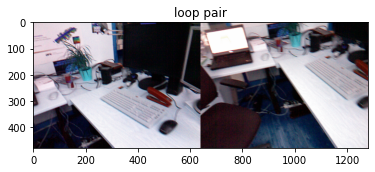

Found an edge from 138 to 136


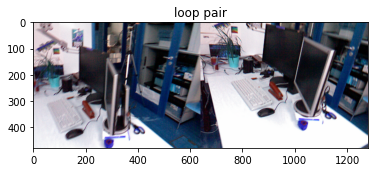

Found an edge from 144 to 142


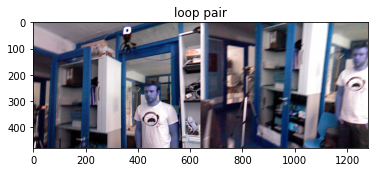

Found an edge from 151 to 149


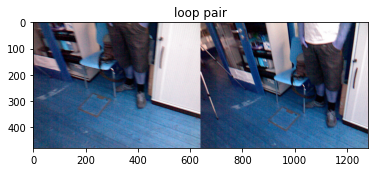

Found an edge from 152 to 150


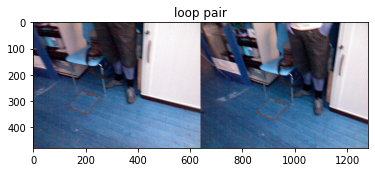

Found an edge from 153 to 151


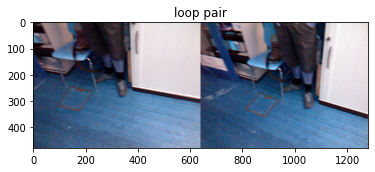

Found an edge from 155 to 153


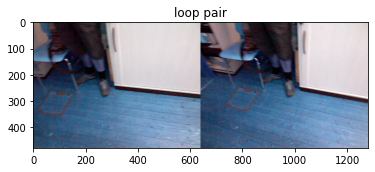

Found an edge from 156 to 153


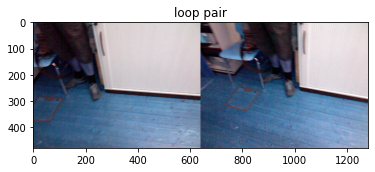

Found an edge from 158 to 156


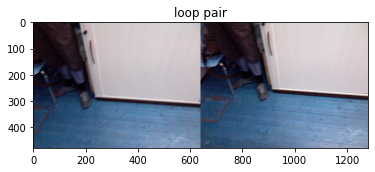

Found an edge from 176 to 174


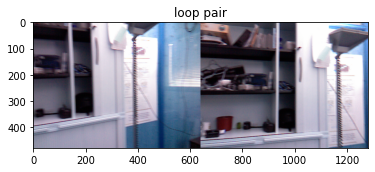

Found an edge from 177 to 175


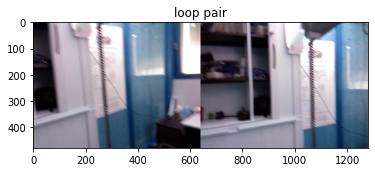

Found an edge from 180 to 178


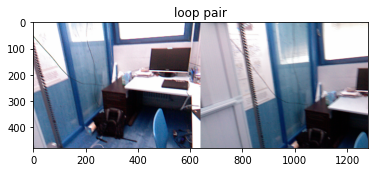

Found an edge from 187 to 183


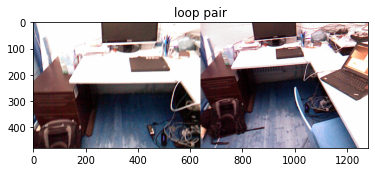

Found an edge from 198 to 196


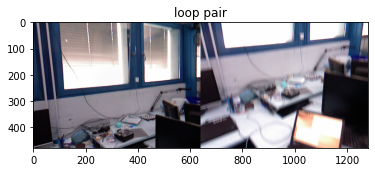

Found an edge from 201 to 199


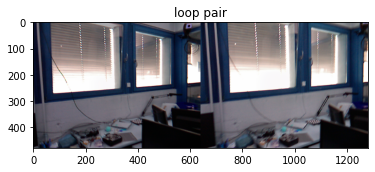

Found an edge from 203 to 201


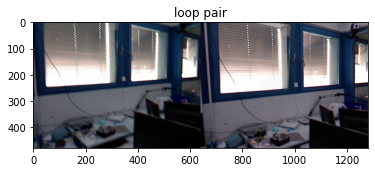

Found an edge from 204 to 201


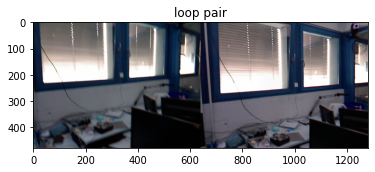

Found an edge from 206 to 204


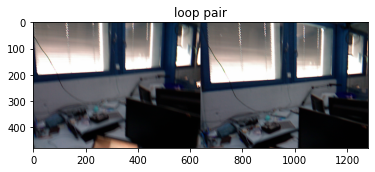

Found an edge from 207 to 205


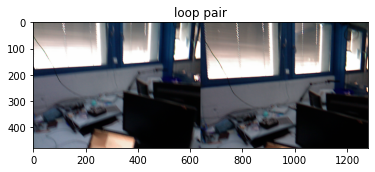

Found an edge from 208 to 206


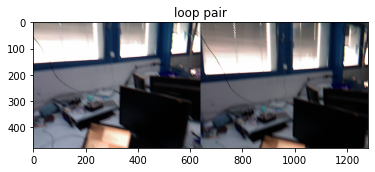

Found an edge from 213 to 16


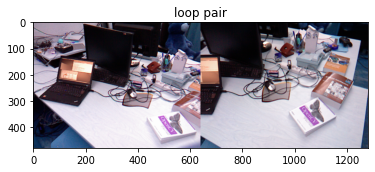

Found an edge from 215 to 19


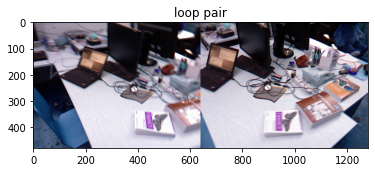

Found an edge from 218 to 22


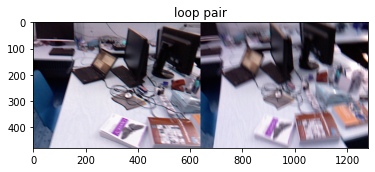

Found an edge from 219 to 22


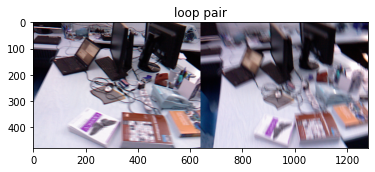

Found an edge from 234 to 53


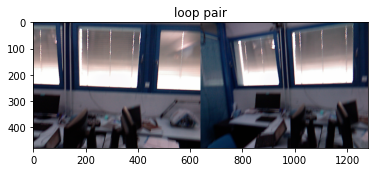

Found an edge from 235 to 229


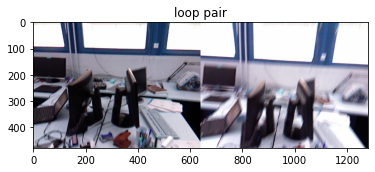

Found an edge from 238 to 59


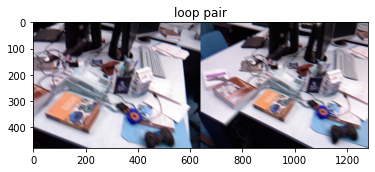

Found an edge from 239 to 59


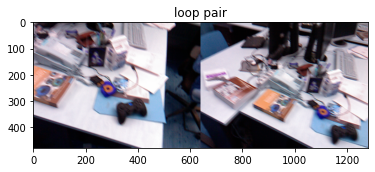

Found an edge from 245 to 243


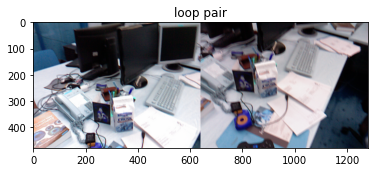

In [8]:
######################### Start Replay #########################

# EXPERIMENT AND ANALYSE.
# Depends on how the loop closure has been detected, 
# there should have various different setup when you debugging the system.
# Add the intermediate output (mainly the optimized pose graph) into the report and discuss/explain them.

from g2o.contrib import SmoothEstimatePropagator

loop_closing = LoopClosing(params)
graph_optimizer = PoseGraphOptimization()
viewer = SimpleMapViewer(params)

replayed_kfs = []
next_id = 0

while( next_id < len(kfs)):

    if(viewer.check_next()):

        kf = kfs[next_id]
        next_id += 1
        
        candidate_image = np.zeros(kf.rgb.image.shape, dtype=np.uint8)
        find_loop = loop_closing.add_keyframe(kf)
        replayed_kfs.append(kf)

        if find_loop:
            graph_optimizer.set_data(kfs, loop_closing.loops)

            before_lc = [g2o.Isometry3d(kf.orientation, kf.position) for kf in kfs]

            d = max(20, len(kfs) * 0.1)
            propagator = SmoothEstimatePropagator(graph_optimizer, d)
            propagator.propagate(graph_optimizer.vertex(kf.loop_keyframe.id))

            graph_optimizer.optimize(20)

            if view_point_cloud:
                graph_optimizer.update_poses(kfs, exclude=[], update_points=True)
            else:
                graph_optimizer.update_poses(kfs, exclude=[])

            candidate_image = kf.loop_keyframe.rgb.image

        image_for_viewer = cv2.hconcat([kf.rgb.image, candidate_image])

        viewer.show_image(image_for_viewer)
        viewer.update(replayed_kfs, find_loop)